In [1]:
import os
import pandas as pd
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset

from PIL import Image

from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from tqdm import tqdm

In [2]:
data_path = "/home/rasteiger/datasets/hack4good/"

In [3]:
# Custom dataloader classs for images with corresponding labels such that pytorch can work with the data
class CustomImageDataset(Dataset):
    
    def __init__(self, img_dir, csv_file, label_name, join_name, class_to_idx, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.csv_file = csv_file
        self.label_name = label_name
        self.join_name = join_name # column used to join img_dir and csv_file
        self.transform = transform
        self.target_transform = target_transform

        # Integer class mapping: Labels classes -> [0, 1, ..., num(labels) - 1] for pytorch
        self.class_to_idx = class_to_idx

    def __len__(self):
        return self.csv_file.shape[0]

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.csv_file.iloc[idx][self.join_name])
        image = Image.open(img_path)

        # Load Label
        label = self.class_to_idx[self.csv_file.iloc[idx][label_name]]

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [4]:
img_dir = data_path + "images"
csv_path = data_path + "labels.csv"

csv_file = pd.read_csv(csv_path)
csv_file['is_damage'] = (csv_file['extent'] >= 20).astype(int)

label_name = 'is_damage'
join_name = 'filename'
class_to_idx = {v:i for i, v in enumerate(csv_file[label_name].unique())} 
num_classes = len(list(class_to_idx.values()))
size = 224

# Perform image augmentation while training to artificially inflate dataset
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=(size, size), scale=(0.8, 1.0)),
    torchvision.transforms.ColorJitter(brightness=0.95),#, contrast=None, saturation=None),
    torchvision.transforms.RandomRotation(degrees = (-15,+15)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# Only resize for validation and test images
val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((size, size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

# 60% Train 20% Validate 20% Test split: https://datascience.stackexchange.com/questions/15135/train-test-validation-set-splitting-in-sklearn
train_csv, val_csv, test_csv = np.split(csv_file.sample(frac=1), [int(.6*len(csv_file)), int(.8*len(csv_file))]) 

train_dataset = CustomImageDataset(img_dir=img_dir, csv_file=train_csv, label_name=label_name, join_name=join_name, transform=train_transforms, class_to_idx=class_to_idx)
val_dataset = CustomImageDataset(img_dir=img_dir, csv_file=val_csv, label_name=label_name, join_name=join_name, transform=val_transforms, class_to_idx=class_to_idx)
test_dataset = CustomImageDataset(img_dir=img_dir, csv_file=test_csv, label_name=label_name, join_name=join_name, transform=val_transforms, class_to_idx=class_to_idx)

In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=64)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=64)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=64)

In [6]:
model = torchvision.models.convnext_tiny(weights='DEFAULT')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.classifier[2] = torch.nn.Linear(768, num_classes, bias=True) # Since, we have only two classes, change the last layer
model = torch.nn.DataParallel(model) # Ensure that we use all gpus available
model.to(device)

DataParallel(
  (module): ConvNeXt(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=96, out_features=384, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=384, out_features=96, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (1): Permute()
            (2): LayerNorm((96,)

In [7]:
def train_step(model, data_loader, criterion, optimizer):
    model.train()
    
    tot_loss = 0
    pred_labels, true_labels = [], []
    
    for i, (img, label) in enumerate(tqdm(train_loader)):
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        
        output = model(img)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        pred = torch.argmax(output, dim=1)
        
        pred_labels.append(pred.detach().cpu().numpy())
        true_labels.append(label.detach().cpu().numpy())
        
        tot_loss += loss
    
    all_pred = np.concatenate(pred_labels)
    all_true = np.concatenate(true_labels)
    
    f1 = f1_score(all_pred, all_true, average='macro')
    accuracy = balanced_accuracy_score(all_pred, all_true)
    tot_loss /= len(data_loader)
    
    line = '{:>8.4f} | {:>8.4f} | {:>5.4f}'.format(f1, accuracy, tot_loss.detach().cpu().numpy())
    print(line, end=' \t \t ')
    
    return accuracy, tot_loss
    
def evaluate(model, data_loader, criterion, is_test=False):
    
    model.eval()
    
    tot_loss = 0
    pred_labels, true_labels = [], []
    
    with torch.no_grad():
        for i, (img, label) in enumerate(tqdm(data_loader)):
            img, label = img.to(device), label.to(device)
       
            output = model(img)
            loss = criterion(output, label)
            
            pred = torch.argmax(output, dim=1)
        
            pred_labels.append(pred.detach().cpu().numpy())
            true_labels.append(label.detach().cpu().numpy())

            tot_loss += loss
        
    all_pred = np.concatenate(pred_labels)
    all_true = np.concatenate(true_labels)
    
    f1 = f1_score(all_true, all_pred, average='macro')
    accuracy = balanced_accuracy_score(all_true, all_pred)
    precision = precision_score(all_true, all_pred, average='macro')
    recall = recall_score(all_true, all_pred, average='macro')
        
    tot_loss /= len(data_loader)

    if is_test:
        cf_matrix = confusion_matrix(all_true, all_pred)
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = ["Damage","No Damage"], columns = ["Damage","No Damage"])
        plt.figure(figsize = (12,7))
        sns.heatmap(df_cm, annot=True)
                   
    line = '{:>8.4f} | {:>8.4f} | {:>9.4f} | {:>6.4f} | {:>5.4f}'.format(f1, accuracy, precision, recall, tot_loss.detach().cpu().numpy())
    print(line)
    
    return accuracy, tot_loss

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.00)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
best_loss = 1e20
print('{:>10} | {:>8} | {:>8} | {:>5} \t \t {:>10} | {:>8} | {:>8} | {:>9} | {:>6} | {:>5}'.format(
    "Training", "f1-score", "accuracy", "loss", "Val", "f1-score", "accuracy", "precision", "recall", "loss"))

for epoch in range(10):
    
    print(f"{epoch:>10} |", end=' ')
    train_step(model, train_loader, criterion, optimizer)
    print(f"{epoch:>10} |", end=' ')
    
    acc, loss = evaluate(model, val_loader, criterion)
    
    if (loss < best_loss):
        best_loss = loss
        #torch.save(model, 'current_best_model.pt')

  Training | f1-score | accuracy |  loss 	 	        Val | f1-score | accuracy | precision | recall |  loss
         0 | 

  0%|                                                                                           | 0/405 [00:00<?, ?it/s]/home/rasteiger/miniconda3/envs/h4g/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
100%|█████████████████████████████████████████████████████████████████████████████████| 405/405 [00:47<00:00,  8.52it/s]


  0.6876 |   0.7215 | 0.5360 	 	          0 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:09<00:00, 14.21it/s]


  0.7285 |   0.7174 |    0.7774 | 0.7174 | 0.4823
         1 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 405/405 [00:47<00:00,  8.54it/s]


  0.7660 |   0.7774 | 0.4536 	 	          1 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:09<00:00, 14.14it/s]


  0.7796 |   0.7788 |    0.7805 | 0.7788 | 0.4405
         2 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 405/405 [00:47<00:00,  8.61it/s]


  0.7880 |   0.7947 | 0.4238 	 	          2 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:09<00:00, 14.21it/s]


  0.7748 |   0.7649 |    0.7967 | 0.7649 | 0.4298
         3 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 405/405 [00:47<00:00,  8.55it/s]


  0.7984 |   0.8048 | 0.4068 	 	          3 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:09<00:00, 14.13it/s]


  0.7896 |   0.7867 |    0.7932 | 0.7867 | 0.4187
         4 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 405/405 [00:48<00:00,  8.30it/s]


  0.8067 |   0.8121 | 0.3893 	 	          4 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 13.16it/s]


  0.7828 |   0.7754 |    0.7959 | 0.7754 | 0.4174
         5 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 405/405 [02:17<00:00,  2.95it/s]


  0.8261 |   0.8293 | 0.3610 	 	          6 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 12.79it/s]


  0.7959 |   0.7917 |    0.8015 | 0.7917 | 0.4158
         7 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 405/405 [00:49<00:00,  8.12it/s]


  0.8333 |   0.8371 | 0.3445 	 	          7 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 12.86it/s]


  0.7949 |   0.7893 |    0.8032 | 0.7893 | 0.4157
         8 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 405/405 [00:49<00:00,  8.15it/s]


  0.8415 |   0.8451 | 0.3333 	 	          8 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 12.57it/s]


  0.7970 |   0.7916 |    0.8052 | 0.7916 | 0.4106
         9 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 405/405 [00:48<00:00,  8.35it/s]


  0.8515 |   0.8555 | 0.3157 	 	          9 | 

100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 12.33it/s]

  0.7891 |   0.8006 |    0.7855 | 0.8006 | 0.4338


f1-score | accuracy | precision | recall |  loss


100%|█████████████████████████████████████████████████████████████████████████████████| 135/135 [00:10<00:00, 12.48it/s]

  0.7969 |   0.8099 |    0.7930 | 0.8099 | 0.4338


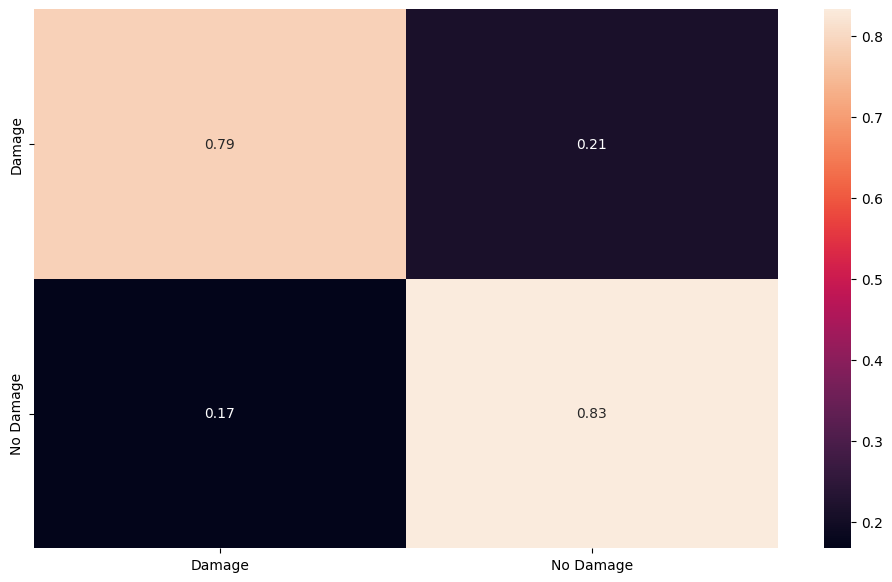

In [10]:
print('{:>8} | {:>8} | {:>9} | {:>6} | {:>5}'.format("f1-score", "accuracy", "precision", "recall", "loss"))
a, l = evaluate(model, test_loader, criterion, True)

In [11]:
csv_file['is_damage'].value_counts()

is_damage
0    13464
1     8090
Name: count, dtype: int64